## Calculate an accuracy value in HSLE Dataset
### Data 
    
    - Collected from weight.csv file and applied two columns( weighted_value, IsHS) only.
    - Performed data preprocessing step. 
    - Manipulated four models(Random-Forest, LogisticRegression,AdaBoostClassifier and KNeighborsClassifier)
    - Selected the best model to predict a label value whether a HS Comment or No HS Comment.
    - Calculated a confusion matrix (Accuracy, Precision,Recall, F1-Score). 


In [1]:
import pandas as pd
import numpy as np 
from glob import glob 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

import math 
import gspread 
import os 
from oauth2client.service_account import ServiceAccountCredentials
import pickle
import joblib

In [2]:
scope = ["https://spreadsheets.google.com/feeds", 'https://www.googleapis.com/auth/drive']

creds= ServiceAccountCredentials.from_json_keyfile_name('hs_data_sheet.json',scope)
client = gspread.authorize(creds)
HS_Accuracy =client.open('HS_Accuracy')

weighted_value_by_lexicon = HS_Accuracy.get_worksheet(2)   #annotate_here

weighted_value_by_lexicon_val=weighted_value_by_lexicon.get_all_records()
weighted_value_by_lexicon_list=[]
for index in range(len(weighted_value_by_lexicon_val)):
    for key in weighted_value_by_lexicon_val[index]:
        if key=='LexFound':
            LexFound_key=weighted_value_by_lexicon_val[index][key]
        elif key=='MsgUniSeg':
            MsgUniSeg_key=weighted_value_by_lexicon_val[index][key]
        elif key=='NewHSWordInSentence':
            NewHSWordInSentence_key=weighted_value_by_lexicon_val[index][key]
        elif key=='Weighted_Value':
            Weighted_Value_key =weighted_value_by_lexicon_val[index][key]
        elif key=='IsHS':
            IsHS=weighted_value_by_lexicon_val[index][key]
        else:pass
    weighted_value_by_lexicon_list.append([LexFound_key,MsgUniSeg_key,NewHSWordInSentence_key,Weighted_Value_key,IsHS])

#Create annotate_here dataframe 
weighted_val_new = pd.DataFrame(weighted_value_by_lexicon_list, columns=['LexFound','MsgUniSeg','NewHSWordInSentence','Weighted_Value','IsHS'])

# Preprocessing Step

In [3]:
print(weighted_val_new.dtypes)

LexFound                object
MsgUniSeg               object
NewHSWordInSentence     object
Weighted_Value         float64
IsHS                     int64
dtype: object


In [4]:
# Check missing values in a given dataset
weighted_val_new.isna().sum()

LexFound               0
MsgUniSeg              0
NewHSWordInSentence    0
Weighted_Value         0
IsHS                   0
dtype: int64

In [5]:
weighted_val_new.shape

(15486, 5)

In [6]:
weighted_val_updated =weighted_val_new.dropna()

In [7]:
weighted_val_updated.isna().sum()

LexFound               0
MsgUniSeg              0
NewHSWordInSentence    0
Weighted_Value         0
IsHS                   0
dtype: int64

In [8]:
weighted_val_updated.shape

(15486, 5)

In [9]:
# Statistical summary of all attributes

statistical_summary = weighted_val_updated.describe()
statistical_summary

,Weighted_Value,IsHS
count,15486.000000,15486.000000
mean,0.234986,0.197081
std,0.213220,0.397807
min,0.000000,0.000000
25%,0.102564,0.000000
50%,0.200717,0.000000
75%,0.324226,0.000000
max,3.642369,1.000000


#### Here, maximum number of weighted_value is 3.642369 and minimum number of weighted_value is 0.0. 

In [10]:
weighted_val_updated.isna().sum()

LexFound               0
MsgUniSeg              0
NewHSWordInSentence    0
Weighted_Value         0
IsHS                   0
dtype: int64

In [11]:
weighted_val_updated['IsHS'].value_counts()

0    12434
1     3052
Name: IsHS, dtype: int64

In [12]:
X=weighted_val_updated[['Weighted_Value']]

In [13]:
 weighted_val_updated['IsHS'].unique()

array([1, 0])

In [14]:
# y is a vector, hence we use dot to access 'label'
y = weighted_val_updated[['IsHS']]

In [15]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)

In [16]:
## Apply RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
ytrain_pred = rf_model.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = (rf_model.predict_proba(X_test))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

RF train roc-auc: 0.7900385861730485
RF test roc-auc: 0.7642789925675101


In [17]:
log_classifier=LogisticRegression()
log_classifier.fit(X_train, y_train)
ytrain_pred = log_classifier.predict_proba(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = log_classifier.predict_proba(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.7548962547385627
Logistic test roc-auc: 0.773258143261777


In [18]:
ada_classifier=AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
ytrain_pred = ada_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = ada_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.7632208262657045
Adaboost test roc-auc: 0.7758203823792487


In [19]:
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
ytrain_pred = knn_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = knn_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.6574780373006519
Adaboost test roc-auc: 0.6615974263139961


In [20]:
pred=[]
for model in [rf_model,log_classifier,ada_classifier,knn_classifier]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print(' test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

 test roc-auc: 0.7549218284138343


In [21]:
pd.concat(pred,axis=1).mean(axis=1)

0       0.183330
1       0.579337
2       0.376211
3       0.183330
4       0.256974
          ...   
3093    0.248697
3094    0.183330
3095    0.322875
3096    0.287493
3097    0.255491
Length: 3098, dtype: float64

In [22]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
# thresholds

In [23]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()


,thresholds,accuracy
36,0.539943,0.818593
25,0.609772,0.818593
27,0.590793,0.818270
30,0.579337,0.818270
59,0.440489,0.818270


In [24]:
# print the first predicted probabilities of class membership
y_pred_class =(rf_model.predict_proba(X_test)[:,1] >0.3).astype(bool)

In [25]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


[[2074  422]
 [ 307  295]]


In [26]:
# use float to perform true division, not integer division
Accuracy =(TP + TN) / float(TP + TN + FP + FN)

print("Accuracy  :  ",Accuracy)
print("Accuracy  :  ",metrics.accuracy_score(y_test, y_pred_class))

Accuracy  :   0.7646868947708199
Accuracy  :   0.7646868947708199


In [27]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.23531310522918011
0.23531310522918014


In [28]:
sensitivity_recall = TP / float(FN + TP)   # True Positive Rate


print("Recall           : ",sensitivity_recall)

print("Metric Recall    : ",metrics.recall_score(y_test, y_pred_class))

Recall           :  0.4900332225913621
Metric Recall    :  0.4900332225913621


In [29]:
specificity = TN / (TN + FP)  

print(specificity)

0.8309294871794872


In [30]:
false_positive_rate = FP / float(TN + FP)   # False Positive Rate

print(false_positive_rate)
print(1 - specificity)


0.16907051282051283
0.16907051282051277


In [31]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.41143654114365413
0.41143654114365413


In [32]:
F1=2*((precision*sensitivity_recall)/(precision+sensitivity_recall))


In [33]:
print("Accuracy     :   ",Accuracy)
print("Precision    :   ",precision)
print("Recall       :   ",sensitivity_recall)
print("F1 Score     :   ",F1)

Accuracy     :    0.7646868947708199
Precision    :    0.41143654114365413
Recall       :    0.4900332225913621
F1 Score     :    0.4473085670962851


In [34]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

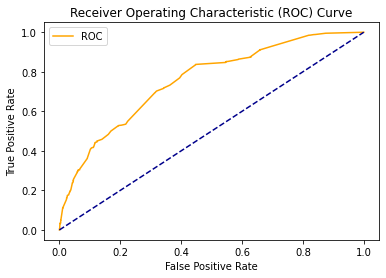

In [35]:
plot_roc_curve(fpr,tpr)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2496
           1       0.41      0.49      0.45       602

    accuracy                           0.76      3098
   macro avg       0.64      0.66      0.65      3098
weighted avg       0.78      0.76      0.77      3098



In [38]:
from sklearn.metrics import precision_recall_fscore_support as score

In [39]:
y_pred = rf_model.predict(X_test)

# print the first predicted probabilities of class membership
y_pred_class =(rf_model.predict_proba(X_test)[:,1] >=0.3).astype(bool)


precision, recall,fscore,support = score(y_test,y_pred_class,pos_label=1,average='binary')

print('Precision : {} / Recall : {}  / F1 Score : {}'.format(round(precision,3),round(recall,3),round(fscore,3)))

Precision : 0.411 / Recall : 0.49  / F1 Score : 0.447


In [40]:
model_Name = 'final_lexfound_teset.pkl'
joblib.dump(model,model_Name)

['final_lexfound_teset.pkl']

In [41]:
# load the model from disk

loaded_model = joblib.load(model_Name)
result = loaded_model.score(X_test,y_test)
print(result)

0.8137508069722401


## Prediction Pipeline

In [49]:
import calculate_weight_func as weight 
import pandas as pd 
from importlib import reload
from tqdm import tqdm

reload(weight);

In [50]:
weight_value = pd.read_csv('example.csv')

In [51]:
lexicon_weight = weight.weight_calculation(weight_value)

In [52]:
lexicon_weight

[['ကုလားတွေ',
  'ဗမာတွေ ကို ပဲ အပြစ်ပြော ရဲ ကျ တယ် ဟို ရင် တစ် ချိန် က ဘူး သီး တောင် မောင် တော မှာ ကု လ ားတွေ ဖင် ဝိုင်း လိုး တော့ ကု လ ား တွေ ကို မ ပြော ရဲ ကျ ဘူး ဖင် ချ မှာ ကြောက် လို့ လား',
  nan,
  0.6492536999999999],
 ['ကုလားတွေ',
  'ပြည် သူ တွေ အကာ ကွယ် လုပ် ချင် လုပ် မ လုပ် ချင် နေကာ ကွယ် နေ တဲ့ သူ တွေ လည်း အသေ ပဲး သေ ရဲ ရင်ကာ ကွယ် ဘယ်သူ မ လွတ် တော့ ဘူး ပြည် သူ ကို ချစ် ရင် ပြည် သူ တွေ ဒုက္ခ မ ရောက် အောင် လုပ် လား ထွန်း မြတ် နိူင် ခိုင် သုခ ပြေား လိုက် ရင် ပြည် သူ ချစ် တော် ကြီး ဘာ တွေ ကာကွယ် ဖူး ပီ လည်း ပြည် သူ တွေ ကို မူ စ လင် ကုလားတွေ ဖင် လုပ် ပီး သက် ပြစ် တာ တောင် ဘာ မ လုပ် ပေး တဲ့ AA သူပုန် မူ စ လင် ကုလား အဖေ ခေါ် တဲ့ ထွန် မြတ် နိူင် ခိုင် သုခ',
  'AA သူပုန်,  မူ စ လင် ကုလား',
  2.0845478],
 ['ကြံ့ဖွတ်',
  'ဒီလို ပဲ မ ထူး ဇာတ်ခင်း ပြီး မိုက်တွင်းနက် နေ မယ် ဆို ရင် တိုင်းပြည် လည်း ဆင်းရဲ တွင်း က ထွက် နိုင် မှာ မဟုတ် ဘူး ။ ကြံ့ဖွတ် လည်း န လန် ထူ နိုင် စရာ အကြောင်း မ မြင် ၊ နစ် ပြီး ရင်း နစ် မယ့် လူ တွေ တိုင်း ပြ ည ကို ပါ ဆွဲချ ချင် နေ တာ',
  nan,
  0.3242259],
 ['စစ်ခွေး',
 

In [53]:
def Extract(lexicon_weight): 
    return [[item[-1]] for item in lexicon_weight] 

In [54]:
X_test_input = Extract(lexicon_weight)

In [55]:
X_test_input

[[0.6492536999999999], [2.0845478], [0.3242259], [0.3583441]]

In [56]:
#make a prediction
ynew =rf_model.predict(X_test_input)

ynew_pd = pd.Series(ynew, name='IsHS')
ynew_pd

0    1
1    1
2    0
3    0
Name: IsHS, dtype: int64

In [57]:
# Show a result pandas dataframe
weight_prediction_result = pd.concat([weight_value, ynew_pd], axis=1)

In [58]:
weight_prediction_result

,LexFound,MsgUniSeg,NewHSWordInSentence,IsHS
0,ကုလားတွေ,ဗမာတွေ ကို ပဲ အပြစ်ပြော ရဲ ကျ တယ် ဟို ရင် တစ် ...,NaN,1
1,ကုလားတွေ,ပြည် သူ တွေ အကာ ကွယ် လုပ် ချင် လုပ် မ လုပ် ချင...,"AA သူပုန်, မူ စ လင် ကုလား",1
2,ကြံ့ဖွတ်,ဒီလို ပဲ မ ထူး ဇာတ်ခင်း ပြီး မိုက်တွင်းနက် နေ ...,NaN,0
3,စစ်ခွေး,ဒေ အစိုးရ လည်း အမှတ်မရှိ အရင် တုံး က လည်း တစ်ခ...,NaN,0
